In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1a) Import necessary libraries and dataset, compute the matrix of monthly returns

In [2]:
#Load file and into dateframe
monthlyClosing_inSample = 'monthly_closings_2018_to_2020.csv'
monthlyClosing_outSample = 'monthly_closings_2021.csv'

df1 = pd.read_csv(monthlyClosing_inSample)
df2 = pd.read_csv(monthlyClosing_outSample)

df2 = df2.iloc[:-3,:]

#Remove date
price = df1.iloc[:,1:]

#Calculate monthly return as percent change of monthly closing values, reset indices 
ret = price.pct_change().iloc[1:,:]
ret.reset_index(inplace = True, drop = True)

### 1b) Compute the covariance matrix and means of the percent change matrix

In [3]:
# Compute the covariance matrix of the percent change of prices
Q = ret.cov().to_numpy()

# Compute the mean for each column 
mu = np.array(np.mean(ret, axis = 0))

# Store number of features 
n = ret.shape[1] 

### 1c) Solve for the minimum variance portfolio

In [4]:
# Create optimization variable w1, 26 total variables 
w1 = cp.Variable(n)

# Form the problem , minimize
constraints1 = [sum(w1) == 1 , w1 >= 0]
prob1 = cp.Problem(cp.Minimize(cp.quad_form(w1, Q)) , [sum(w1) == 1 , w1 >= 0])

#Solve Problem
prob1.solve(verbose=False)

# matrix of allocations which offers the minimum variance 
w_minVar = w1.value #solution value: minimum variance 
print(w_minVar)

#Compute the variance of the portfolio
var_minVar = np.dot(w_minVar, np.dot(Q, w_minVar)) #variance
print(var_minVar)

#Compute the return of the portfolio
ret_minVar = np.dot(mu, w_minVar) #expected return
print(ret_minVar)

[ 2.34711076e-19  5.74341943e-20  8.04974643e-21  8.47497298e-20
  1.98801020e-20  1.09424374e-20  2.73065413e-20  2.72299411e-19
  5.54485957e-02  1.08374508e-19  8.96592846e-20  6.59194971e-01
 -6.72526425e-20  2.57096580e-20  1.76013193e-03  8.87191244e-02
  5.48842212e-02 -5.82451239e-20 -4.53773627e-19  3.42087380e-20
 -3.00374544e-20  8.76648789e-20  9.01180838e-02 -1.21197912e-21
  4.98748717e-02]
0.0009278939303461066
0.008653285914910979


### 1d) Solve for the maximum variance portfolio

In [5]:
# Create optimization variable w2, 26 total variables 
w2 = cp.Variable(n)

constraints2 = [sum(w2) == 1, w2 >= 0]
prob2 = cp.Problem(cp.Maximize(mu.T@w2), constraints2)
                   
# Solve the problem 
prob2.solve(verbose=False)

# matrix of allocations which offers th
w_maxRet = w2.value #solution value: maximum expected return
print(w_maxRet)

#Compute the variance of the portfolio
var_maxRet = np.dot(w_maxRet, np.dot(Q, w_maxRet)) #variance
print(var_maxRet)

#Compute the return of the portfolio
ret_maxRet = np.dot(mu, w_maxRet) #expected return
print(ret_maxRet)

[4.00446549e-11 2.33109317e-11 2.11897368e-11 2.02514107e-11
 2.13526338e-11 2.10766681e-11 2.36702200e-11 2.30281295e-11
 2.20156300e-11 1.84127151e-11 1.42266925e-11 1.97676588e-11
 1.08469522e-09 1.88147929e-11 2.37055006e-11 1.85314364e-11
 2.26815434e-11 2.41212013e-11 9.99999998e-01 1.68558540e-11
 8.78989931e-12 2.30303345e-11 2.19747289e-11 2.02437383e-11
 1.72961027e-11]
0.3397485196506799
0.10211634693131112


### 1e) Compute the classical Markowitz efficient frontier

In [6]:
#Create tareget ranges for portfolio returns
targetLen = 50
#targetRet = np.linspace(ret_minVar,ret_maxRet,50)
targetRet = np.linspace(ret_minVar,ret_maxRet,targetLen)

# Define optimization problem and compute one portfolio on efficient frontier
w = cp.Variable(n)
eps = cp.Parameter()

constraints3 = [mu.T@w >= eps,sum(w) == 1,w >= 0]
prob3 = cp.Problem(cp.Minimize(cp.quad_form(w, Q)), constraints3)

# Compute efficient frontier
w_front_clas = []
var_front_clas = []
ret_front_clas = []
for epsilon in targetRet:
    eps.value = epsilon
    prob3.solve()
    w_front_clas.append(w.value)
    var_front_clas.append(np.dot(w.value, np.dot(Q, w.value)))
    ret_front_clas.append(np.dot(mu, w.value))

### 1f) Compute the resampled efficient frontier

In [7]:
sample_size = ret.shape[0] 
repetition = 50

#set variables for storing results
Q_resample_list, mu_resample_list, var_minVar_list, ret_minVar_list = [], [], [], []
var_maxRet_list, ret_maxRet_list, w_frontC_list, var_frontC_list, ret_frontC_list = [], [], [], [], []

#Usa a random seed so that results will be consistent 
np.random.seed(10)

#Resample by taking n (sample size) draws from the original input
for i in range(repetition):
    
    
    #resample by drawing from the multivariate normal distribution with mu and Q
    x_resample = np.random.multivariate_normal(mu,Q,size=sample_size)
    x_resample = pd.DataFrame(x_resample,columns=ret.columns)
    
    #Calculate the new mean vector (mu_resample) and new variance-covariance matrix (Q _resample) 
    #resampled mu and Q
    mu_resample = np.array(np.mean(x_resample, axis = 0))
    Q_resample = x_resample.cov().to_numpy()
    
    #Compute minimum variance
    n = ret.shape[1] 
    w1 = cp.Variable(n)
    # Form the problem , minimize
    constraints1 = [sum(w1) == 1 , w1 >= 0]
    prob1 = cp.Problem(cp.Minimize(cp.quad_form(w1, Q_resample)) , [sum(w1) == 1 , w1 >= 0])

    #Solve Problem
    prob1.solve(verbose=False)

    w_minVar = w1.value #solution value: minimum variance
    var_minVar = np.dot(w_minVar, np.dot(Q_resample, w_minVar)) #variance
    ret_minVar = np.dot(mu_resample, w_minVar) #expected return

    #compute maximum expected return
    w2 = cp.Variable(n)

    constraints2 = [sum(w2) == 1, w2 >= 0]
    prob2 = cp.Problem(cp.Maximize(mu_resample.T@w2), constraints2)
                   
    # Solve the problem 
    prob2.solve(verbose=False)

    w_maxRet = w2.value #solution value: maximum expected return
    var_maxRet = np.dot(w_maxRet, np.dot(Q_resample, w_maxRet)) #variance
    ret_maxRet = np.dot(mu_resample, w_maxRet) #expected return

    #target return
    targetRet = np.linspace(ret_minVar,ret_maxRet,50)
    
    # Define optimization problem and compute one portfolio on efficient frontier
    w_re = cp.Variable(n)
    eps_re = cp.Parameter()
    
    constraints4 = [mu_resample.T@w_re >= eps_re,sum(w_re) == 1,w_re >= 0]
    prob4 = cp.Problem(cp.Minimize(cp.quad_form(w_re, Q_resample)), constraints4)
    
    # Compute efficient frontier
    w_front_re = []
    var_front_re = []
    ret_front_re = []
    for epsilon in targetRet:
        eps_re.value = epsilon
        prob4.solve()
        w_front_re.append(w_re.value)
        var_front_re.append(np.dot(w_re.value, np.dot(Q_resample, w_re.value)))
        ret_front_re.append(np.dot(mu_resample, w_re.value))
    
    #Store results for each resampling
    Q_resample_list.append(Q_resample)
    mu_resample_list.append(mu_resample)
    var_minVar_list.append(var_minVar)
    ret_minVar_list.append(ret_minVar)
    var_maxRet_list.append(var_maxRet)
    ret_maxRet_list.append(ret_maxRet)
    w_frontC_list.append(w_front_re) 
    var_frontC_list.append(var_front_re)
    ret_frontC_list.append(ret_front_re)

#compute the average weights at each return level

w_frontC_avg = np.mean(w_frontC_list, axis=0)
average_weight_list = list(w_frontC_avg)

#compute the resampled efficient frontier based on the average weights and orignial mu & Q
w_frontC_resample, var_frontC_resample, ret_frontC_resample =[], [], []

for i in range(len(w_frontC_avg)):
    w_frontC_resample.append(w_frontC_avg[i])
    var_frontC_resample.append(np.dot(w_frontC_avg[i], np.dot(Q, w_frontC_avg[i])))
    ret_frontC_resample.append(np.dot(mu, w_frontC_avg[i]))

### 2a) On the classical efficient frontier, find the minimum variance, maximum return, and Sharpe ratio portfolio weights

In [8]:
riskFreeRate = 0.002

In [9]:
#Determine weights of minimum variance and maximum return along the efficient frontier 

#Min variance
orig_weights_minVar = w_front_clas[0]
print(orig_weights_minVar)

#Max return 
orig_weights_maxRet = w_front_clas[targetLen - 1]
print(orig_weights_maxRet)

#Compute sharp ratio 
ret_array_clas = np.array(ret_front_clas)
var_array_clas = np.array(var_front_clas)

sharpe_array_clas = (ret_array_clas - riskFreeRate)/np.sqrt(var_array_clas)

weights_sharpe_clas = w_front_clas[sharpe_array_clas.argmax()]
print(sharpe_array_clas)
print(sharpe_array_clas.argmax())
print(weights_sharpe_clas)

[ 3.27231831e-19 -1.14158479e-20 -8.31044264e-22  1.11997265e-19
  1.90860299e-20  1.70009911e-20 -2.67194251e-20  8.07705709e-20
  5.54485957e-02  8.99771706e-20  9.08772980e-20  6.59194971e-01
  9.71760135e-20  3.48214411e-20  1.76013193e-03  8.87191244e-02
  5.48842212e-02 -8.25234018e-20 -1.26897129e-20  4.97872186e-20
  4.42501729e-20  2.33161871e-20  9.01180838e-02  8.74792459e-21
  4.98748717e-02]
[-3.69310785e-06 -1.73732232e-05 -1.46513622e-05 -1.39387928e-05
 -1.48461009e-05 -1.45522788e-05 -1.78618558e-05 -1.64950255e-05
 -1.54703989e-05 -1.27246575e-05 -1.08433441e-05 -1.35992466e-05
  3.02308681e-03 -1.29547906e-05 -1.79986306e-05 -1.28098616e-05
 -1.61873492e-05 -1.93337499e-05  9.97301088e-01 -1.19644126e-05
 -8.72463646e-06 -1.66768143e-05 -1.53960167e-05 -1.39080658e-05
 -1.21554690e-05]
[0.21841729 0.27797437 0.32773841 0.36826892 0.40084006 0.42615505
 0.44633031 0.4624906  0.47545637 0.48589632 0.49435103 0.50109046
 0.50645874 0.51074942 0.5141787  0.51666607 0.518

### 2b) On the resampled efficient fronter, find the minimum variance, maximum return, and Sharpe ratio portfolio weights

In [10]:
#Determine weights of minimum variance and maximum return along the efficient frontier 

#Min variance
re_weights_minVar = w_frontC_resample[0]
print(re_weights_minVar)

#Max return 
re_weights_maxRet =  w_frontC_resample[targetLen - 1]
print(re_weights_maxRet)

#Compute sharp ratio 
ret_array_re = np.array(ret_frontC_resample)
var_array_re = np.array(var_frontC_resample)

sharpe_array_re = (ret_array_re - riskFreeRate)/np.sqrt(var_array_re)

weights_sharpe_re = w_frontC_resample[sharpe_array_re.argmax()]
print(sharpe_array_re)
print(sharpe_array_re.argmax())
print(weights_sharpe_re)

[ 9.16545245e-20  8.83661752e-21  1.49495970e-21  4.54713706e-03
  8.97204306e-04  8.72340545e-21  1.08653715e-20  9.00760231e-03
  4.89770206e-02  3.41713501e-20  1.09409858e-02  6.14444270e-01
 -4.00898404e-20  2.02744275e-02  8.85326645e-03  1.01193351e-01
  5.24172359e-02  5.60672134e-04  5.23278815e-04  8.02281915e-21
  2.99646630e-03  2.18027795e-20  8.58616468e-02  7.51461571e-03
  3.09908186e-02]
[ 1.78373835e-01 -1.49744233e-05 -1.26516184e-05 -1.20909241e-05
 -1.24499135e-05 -1.25229497e-05 -1.55919479e-05 -1.31716873e-05
 -1.40575930e-05 -9.58269296e-06 -8.82553645e-06 -1.21275959e-05
  3.61990080e-01 -1.08472576e-05 -1.55808714e-05 -1.07838032e-05
 -1.40229867e-05 -1.75922516e-05  4.59906560e-01 -1.00519216e-05
 -4.03828760e-06 -1.34928115e-05 -1.34591692e-05 -1.21176950e-05
 -1.04280321e-05]
[0.21460384 0.25505573 0.29157515 0.32434407 0.35285017 0.37741304
 0.39824894 0.41603929 0.4303926  0.4416459  0.45082534 0.45809431
 0.46416566 0.46921137 0.47322903 0.47681685 0.480

### 2c) For each of the 6 portfolios, calculate the expected return on the 2022 (out-of-sample) data for a $1000 investment

In [11]:
#drop date
price2021 = df2.iloc[:,1:]

#We want return for the whole year so only use first and last month
price2021_ = price2021.drop(price2021.index[1:11])
price2021_.reset_index(inplace = True, drop = True)

#Compute percent change
ret_2021 = price2021_.pct_change().iloc[1:,:]

ret_2021

,AMD,OXY,XLF,BABA,F,BAC,CCL,AMC,DAL,FB,...,UNH,MMM,AAL,MULN,QQQ,AAPL,XLE,FXI,JPM,V
1,0.68029,0.446726,0.366112,-0.53201,0.982391,0.522067,0.077665,1.051282,0.029505,0.302017,...,0.521509,0.043312,0.04601,-0.584591,0.269255,0.353931,0.458557,-0.256478,0.261573,0.128286


In [12]:
#From classical frontier find
#Minimum variance portfolio
#orig_weights_minVar
orig_minVar_ret2021 = np.dot(ret_2021, orig_weights_minVar)
print(orig_minVar_ret2021)


#Maximum return portfolio
#orig_weights_maxRet
orig_maxRet_ret2021 = np.dot(ret_2021, orig_weights_maxRet)
print(orig_maxRet_ret2021)

#Sharpe ratio portfolio
#orig_weights_sharpe
orig_sharpe_ret2021 = np.dot(ret_2021, weights_sharpe_clas)
print(orig_sharpe_ret2021)

#From resample frontier find
#Minimum variance portfolio
#re_weights_minVar
re_minVar_ret2021 = np.dot(ret_2021, re_weights_minVar)
print(re_minVar_ret2021)


#Maximum return portfolio
#re_weights_maxRet
re_maxRet_ret2021 = np.dot(ret_2021, re_weights_maxRet)
print(re_maxRet_ret2021)

#Sharpe ratio portfolio
#re_weights_sharpe
re_sharpe_ret2021 = np.dot(ret_2021, weights_sharpe_re)
print(re_sharpe_ret2021)

[0.02822425]
[-0.58210478]
[0.27956668]
[0.06019426]
[-0.02749821]
[0.32823235]


In [13]:
#Compute returns on $1000

#Compute returns on $1000

print('Out-of-sample returns on $1000 investment: \n')
print('On the Classical Efficient Frontier, the minimum variance portfolio returns $' , orig_minVar_ret2021*1000)
print('On the Classical Efficient Frontier, the maximum return portfolio returns $' , orig_maxRet_ret2021*1000)
print('On the Classical Efficient Frontier, the optimal Sharpe ratio portfolio returns $' , orig_sharpe_ret2021*1000 , '\n')
print('On the Resampled Efficient Frontier, the minimum variance portfolio returns $' , re_minVar_ret2021*1000)
print('On the Resampled Efficient Frontier, the maximum return portfolio returns $' , re_maxRet_ret2021*1000)
print('On the Resampled Efficient Frontier, the optimal Sharpe ratio portfolio returns $' , re_sharpe_ret2021*1000)

Out-of-sample returns on $1000 investment: 

On the Classical Efficient Frontier, the minimum variance portfolio returns $ [28.22424688]
On the Classical Efficient Frontier, the maximum return portfolio returns $ [-582.10477944]
On the Classical Efficient Frontier, the optimal Sharpe ratio portfolio returns $ [279.56668474] 

On the Resampled Efficient Frontier, the minimum variance portfolio returns $ [60.19425904]
On the Resampled Efficient Frontier, the maximum return portfolio returns $ [-27.49821058]
On the Resampled Efficient Frontier, the optimal Sharpe ratio portfolio returns $ [328.23234897]


### 3 Plot the classical and resampled efficient frontier

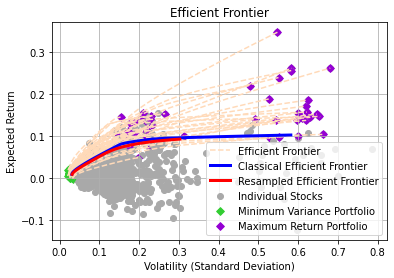

In [14]:
axC = plt.gca()
plt.rcParams['figure.figsize'] = [18, 16]

for i in range(repetition):
    # Plot volatility versus expected return for individual stocks
    axC.scatter(x=np.sqrt(np.diag(Q_resample_list[i])), y=mu_resample_list[i], color='darkgray', label='Individual Stocks' if i == 0 else "")
    
    # Plot volatility versus expected return for mimimum variance portfolio
    axC.scatter(x=np.sqrt(var_minVar_list[i]), y=ret_minVar_list[i], marker='D', s=30,  color='limegreen', label='Minimum Variance Portfolio' if i == 0 else "")

    # Plot volatility versus expected return for maximum return portfolio
    axC.scatter(x=np.sqrt(var_maxRet_list[i]), y=ret_maxRet_list[i],  marker='D', s=30, color='darkviolet', label='Maximum Return Portfolio' if i == 0 else "")

    # Plot efficient frontier
    axC.plot(np.sqrt(var_frontC_list[i]), ret_frontC_list[i], '--', color='peachpuff', label='Efficient Frontier' if i == 0 else "")

#Plot the classical mean-variance efficient frontier
axC.plot(np.sqrt(var_front_clas), ret_front_clas, color='blue', linewidth=3, label='Classical Efficient Frontier')

#Plot the resampled efficient frontier
axC.plot(np.sqrt(var_frontC_resample), ret_frontC_resample, color='red', linewidth=3, label='Resampled Efficient Frontier')

axC.set_xlabel('Volatility (Standard Deviation)')
axC.set_ylabel('Expected Return')
plt.title('Efficient Frontier')
axC.legend(loc="lower right")
axC.grid()
plt.show()

### 4 Plot the portfolio compositions for classical and resampled frontiers

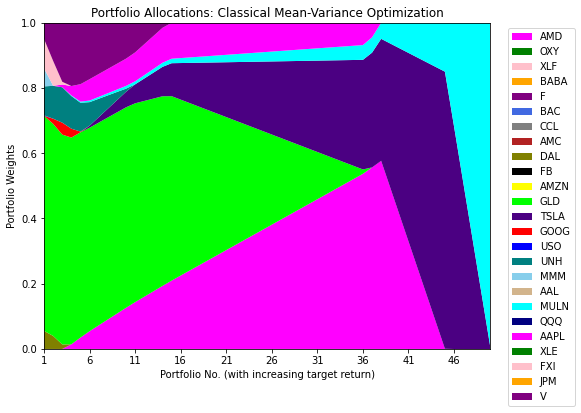

In [15]:
x_tick = np.arange(len(targetRet))+1
color_list = ['fuchsia','green','pink','orange','purple','royalblue','grey','firebrick','olive','black','yellow','lime','indigo','red','blue','teal','skyblue','tan','cyan','navy']
plt.figure(figsize=(8, 6))
plt.stackplot(x_tick, np.array(w_front_clas).T, colors=color_list)
plt.legend(df1.columns[1:], bbox_to_anchor=(1.2, 1))
plt.xlim((1,len(targetRet)))
plt.ylim((0,1))
plt.xticks(np.arange(1,len(targetRet)+1,5))
plt.xlabel("Portfolio No. (with increasing target return)")
plt.ylabel("Portfolio Weights")
plt.title("Portfolio Allocations: Classical Mean-Variance Optimization")
plt.show()

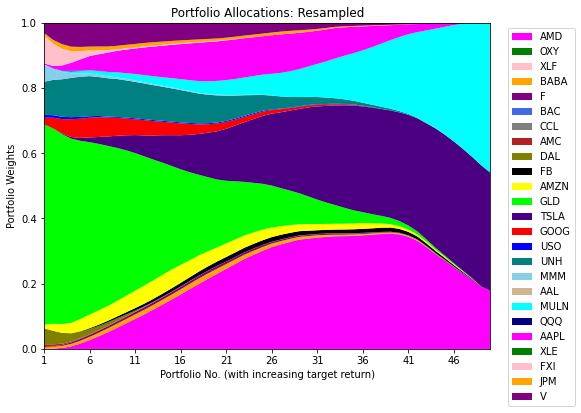

In [16]:
x_tick = np.arange(len(targetRet))+1
color_list = ['fuchsia','green','pink','orange','purple','royalblue','grey','firebrick','olive','black','yellow','lime','indigo','red','blue','teal','skyblue','tan','cyan','navy']
plt.figure(figsize=(8, 6))
plt.stackplot(x_tick, np.array(average_weight_list).T, colors=color_list)
plt.legend(df1.columns[1:], bbox_to_anchor=(1.2, 1))
plt.xlim((1,len(targetRet)))
plt.ylim((0,1))
plt.xticks(np.arange(1,len(targetRet)+1,5))
plt.xlabel("Portfolio No. (with increasing target return)")
plt.ylabel("Portfolio Weights")
plt.title("Portfolio Allocations: Resampled")
plt.show()